In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from pylite.test import *

In [3]:
loss_func = F.cross_entropy
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()
nfs = [8,16,32,64,64]
nh,bs = 50,512

In [4]:
x_train,y_train,x_valid,y_valid = get_mnist_data()
x_train,x_valid = normalize_to(x_train,x_valid)

train_ds, valid_ds = get_ds(x_train,y_train,x_valid,y_valid)
data = TabularDataBunch(*get_dls(train_ds, valid_ds, bs))

In [5]:
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder, partial(AvgStatsCallback,accuracy), partial(BatchTransformXCallback, mnist_view)]

In [6]:
learn = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [7]:
#learn.fit(2)

# Lets build our own batch norm

In [8]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

In [9]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # No bias needed if using bn
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

# Cancel callback

In [10]:
class CancelValidation(Callback):
    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f(): 
            print("Here")
            return True
        return False
    
    def begin_validate(self):
        print("Cancelling validation")
        return True

In [11]:
learn = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)
#learn.add_callbacks(cb_funcs=CancelValidation)

In [12]:
learn.cbs

Validating data
train: [0.27099330078125, tensor(0.9167)]
valid: [0.1494464111328125, tensor(0.9543)]
Validating data
train: [0.095775966796875, tensor(0.9704)]
valid: [0.1189647705078125, tensor(0.9643)]


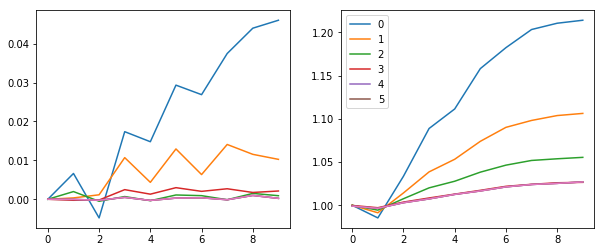

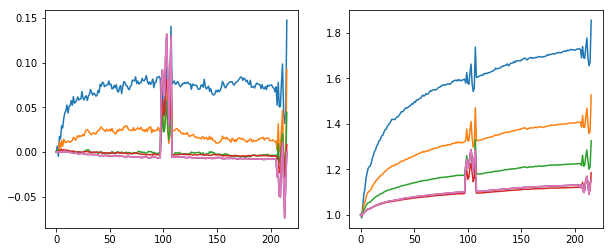

In [13]:
with Hooks(learn.model, append_stats) as hooks:
    learn.fit(2)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss, _ = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss, _ = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

# With Scheduler

In [14]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.1)])